# 01 YRTPremium at Table and ChainerRL
- 手始めにYRT保険料を強化学習で導出してみる．ここでは簡単のため，保険料に応じた利益率・売上の関数は既知とした上で，1時点での販売のみを考える．そして即時報酬として売上×利益率=総利益を考える．状態数は1つだけであり本来は強化学習で扱うような問題設定ではなく，実態として単なる1変数の最適化問題であり（保険料を調整して総利益最大化を行う），あくまで小手調べのようなものである．
- ここでは伝統的なテーブル形式Q学習とChainerRLのDQNを用いた検証を行った．結果として，学習自体はいずれの方法でも可能だが，想定以上に計算時間・計算負荷が必要なことが分かった．

---
## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

---
## 1. Environment
- 需要関数は，0 V beta * (premium - benefit)である．
- 利益関数は，premium - benefit * q = premium - 0.1である．
- 数字サイズに関しては言うまでもなくかなり無茶苦茶だが，ここではNNが学習しやすそうな範囲に収めることにしている．

In [2]:
class Environment(object):
    def __init__(self, benefit=100, beta=0.1, q=0.001):
        self._state = 0
        self._done = False
        self._benefit = benefit
        self._beta = beta
        self._q = q
        self._n = 0
    
    
    def step(self, action):
        if self.done==True:
            return self.state, 0, None, self.done
        
        n = max(0, -self._beta*(action-self._benefit))
        reward = n*(action-self._benefit*self._q)
        self._state = 1
        self._n = n
        self._done = True
        return self.state, reward, None, self.done

    
    def sample(self):
        return np.random.uniform()
    
    
    def reset(self):
        self._state = 0
        self._done = False
    
    
    @property
    def state(self):
        return self._state
    
    
    @property
    def done(self):
        return self._done
    
    
    def best_action(self):
        return self._benefit*(1+self._q)/2
    
    
    def reward(self, action):
        n = max(0, -self._beta*(action-self._benefit))
        reward = n*(action-self._benefit*self._q)
        return reward



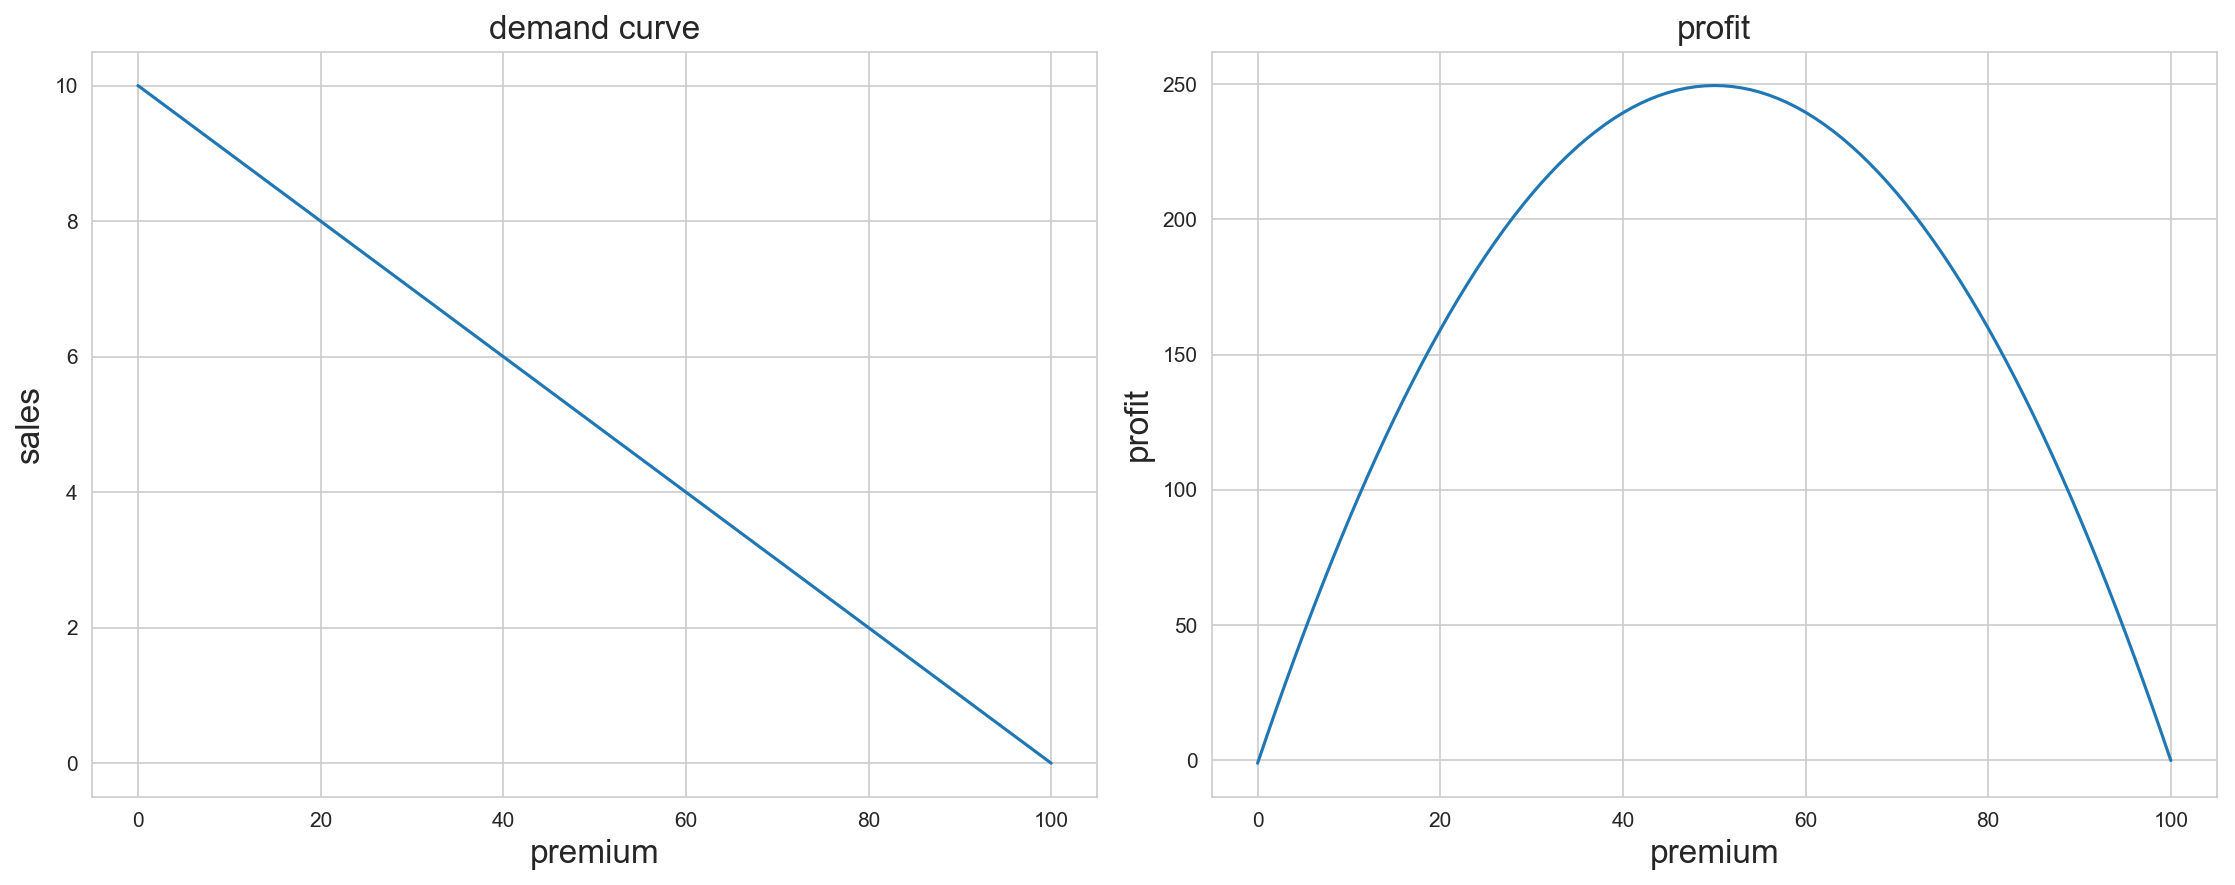

In [3]:
env = Environment()
actions = np.linspace(0, 100, 101)
rewards = []
ns = []

for a in actions:
    _, r, _, _ = env.step(a)
    rewards.append(r)
    ns.append(env._n)
    env.reset()
    
rewards = np.array(rewards)
ns = np.array(ns)


fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=150)
axs[0].plot(actions, ns)
axs[0].set_title('demand curve', size=16)
axs[0].set_xlabel('premium', size=16)
axs[0].set_ylabel('sales', size=16)

axs[1].plot(actions, rewards)
axs[1].set_title('profit', size=16)
axs[1].set_xlabel('premium', size=16)
axs[1].set_ylabel('profit', size=16)

plt.tight_layout()
plt.show()

---
## 2. Table Method

In [4]:
class Agent(object):
    def __init__(self, n_states=1, n_actions=100, gamma=1.0):
        self.Q = np.zeros(shape=(n_states+1, n_actions))  # +1は終端状態に対応．
        self.gamma = gamma

        
    def action(self, state, eps=0.0):
        best_action = np.argmax(self.Q[state])
        if np.random.uniform()<eps:
            best_action = np.random.randint(self.Q.shape[1])
        return best_action
    
    
    def train(self, state_current, action, reward, state_next, alpha=0.01):
        self.Q[state_current, action] += alpha * (reward + self.gamma*np.max(self.Q[state_next]) - self.Q[state_current,action])
        
        

In [5]:
N_EPISODES = 50000
MAX_STEPS = 10000

env = Environment()
agent = Agent(n_states=1, n_actions=100)
historical_best_action = []

for e in range(N_EPISODES):
    historical_best_action.append(np.argmax(agent.Q[0]))
    for t in range(MAX_STEPS):
        state_current = env.state
        action = agent.action(state_current, eps=1.0)
        #print(action)
        state_next, reward, _, done = env.step(action)
        agent.train(state_current, action, reward, state_next, alpha=0.01)
                
        if done==True:
            if e % 10000==0:
                print('{} th episode.'.format(e))
            env.reset()
            break
historical_best_action.append(np.argmax(agent.Q[0]))

print('best_action={}, learned_action = {}'.format(env.best_action(), agent.Q[0].argmax()))

0 th episode.
10000 th episode.
20000 th episode.
30000 th episode.
40000 th episode.
best_action=50.05, learned_action = 51


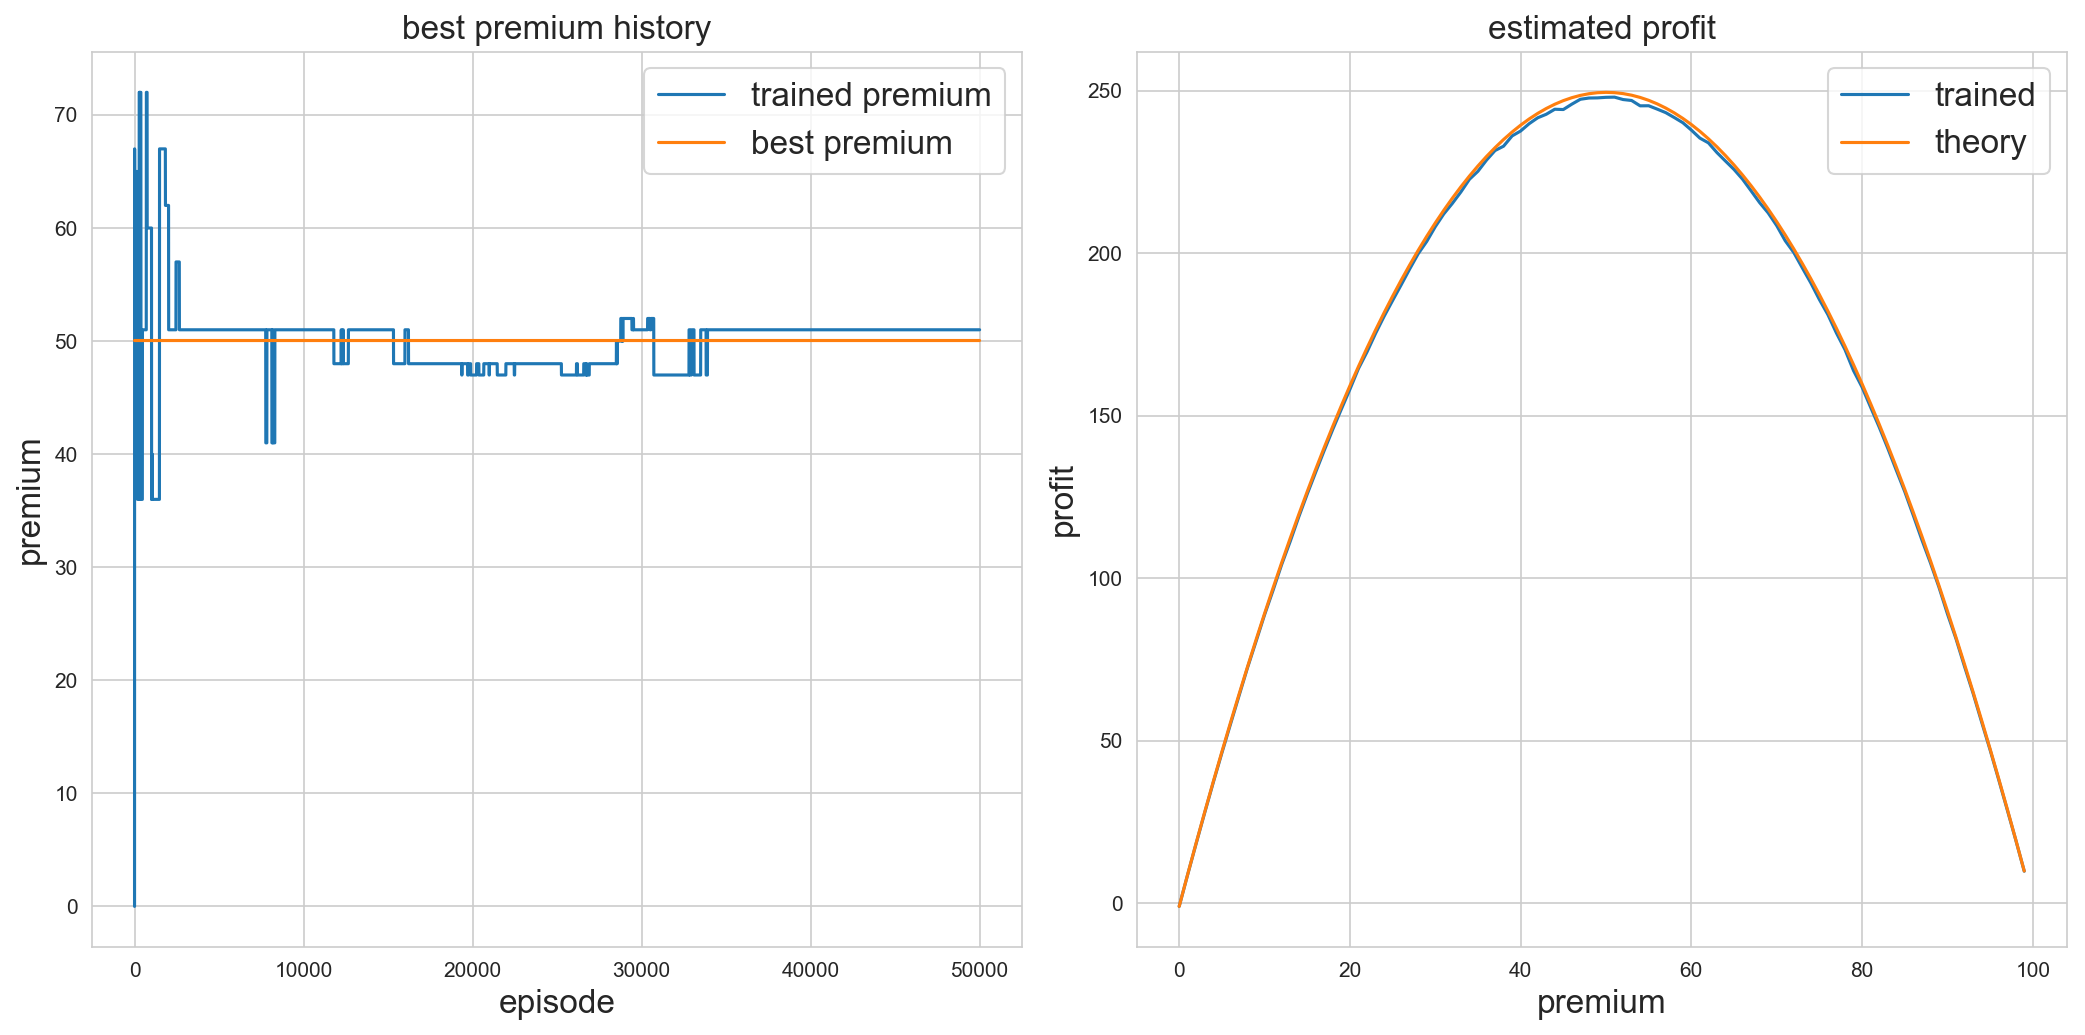

In [6]:
R = []
for a in range(100):
    R.append(env.reward(a))


fig = plt.figure(figsize=(14,7), dpi=150)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(np.array(historical_best_action), label='trained premium')
ax1.plot(np.ones(N_EPISODES)*env.best_action(), label='best premium')
ax1.set_title('best premium history', size=16)
ax1.set_xlabel('episode', size=16)
ax1.set_ylabel('premium', size=16)
ax1.legend(fontsize=16)

ax2.plot(agent.Q[0,:], label='trained')
ax2.plot(np.array(R), label='theory')
ax2.set_title('estimated profit', size=16)
ax2.set_xlabel('premium', size=16)
ax2.set_ylabel('profit', size=16)
ax2.legend(fontsize=16)

plt.tight_layout()
plt.show()

---
## 3. ChainerRL
- 深層強化学習用のフレームワークの1つであるChainerRLでどのように学習できるかを確認する．
- 結論としては，学習自体は可能だが，パラメータ調整がかなり難しく，また，示してはいないが試行錯誤の結果として意外と多くのニューロンが必要である（10,100）．
- データ点（可能な選択肢の数）自体は100個しか無いので，理論上は100のパラメータがあれば十分記憶できる筈で，何故このように多くのニューロンが無いと学習できないのかは分からない．学習方法に問題があるのかもしれない．
- 尚，状態が1つしかなく，更に離散型で行動間の構造を一切考慮できないため，探索を規定するεは1.0固定としている（上と同じ）．

In [7]:
import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl

n_actions = 100
gamma = 0.95
alpha = 0.5

num_episodes =50000


class QFunction(chainer.Chain):
    def __init__(self, obs_size, n_actions=n_actions):
        super(QFunction, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(obs_size, 10)
            self.l2 = L.Linear(10, 100)
            self.l3 = L.Linear(100, n_actions)
            
    def __call__(self, x, test=False):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = chainerrl.action_value.DiscreteActionValue(self.l3(h2))
        
        return y


def random_action():
    return np.random.choice(np.arange(n_actions))


# define Q function and optimizer
q_func = QFunction(1, n_actions)
#optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer = chainer.optimizers.RMSprop(1e-1)
optimizer.setup(q_func)


# define explorer for epsilon-greedy exploring
explorer = chainerrl.explorers.LinearDecayEpsilonGreedy(
    start_epsilon=1.0, end_epsilon=1.0,
    decay_steps=1000,
    random_action_func=random_action
)


# define ExperienceReplayBuffer
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10**4)


# chainer only accept float32 as input.
phi = lambda x: np.array([x]).astype(np.float32, copy=False)


# consolidate all partes to agent.
agent = chainerrl.agents.DQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=10, target_update_interval=20, minibatch_size=256,
    phi=phi
)


# training.
best_actions = []
tried_actions = []
rewards = []
for episode in range(num_episodes):
    state = env.state
    reward = 0  # immidiate reward at t=0
    done = True
    
    for t in range(1):
        action = agent.act_and_train(state, reward)
        next_state, reward, _, done = env.step(action)
        tried_actions.append(action)
        if done:
            break
        # print(action, next_state, reward, done)
    agent.stop_episode_and_train(state, reward, done)
    env.reset()
    
    if episode%10==0:
        action = agent.act(env.state)
        state, reward, _, done = env.step(action)
        best_actions.append(action)
        rewards.append(reward)
        env.reset()
    
    if episode%10000==0:
        print('episode : ', episode, agent.get_statistics())



episode :  0 [('average_q', 0.0), ('average_loss', 0), ('n_updates', 0)]
episode :  10000 [('average_q', 91.32023676782033), ('average_loss', 89.06340519347408), ('n_updates', 950)]
episode :  20000 [('average_q', 176.70739766126852), ('average_loss', 30.02371501074878), ('n_updates', 1950)]
episode :  30000 [('average_q', 248.9051367843078), ('average_loss', 0.2543263176228049), ('n_updates', 2950)]
episode :  40000 [('average_q', 249.49999011931413), ('average_loss', 1.097958438120396e-05), ('n_updates', 3950)]


trained best action = 50, actual reward @ the action = 249.5


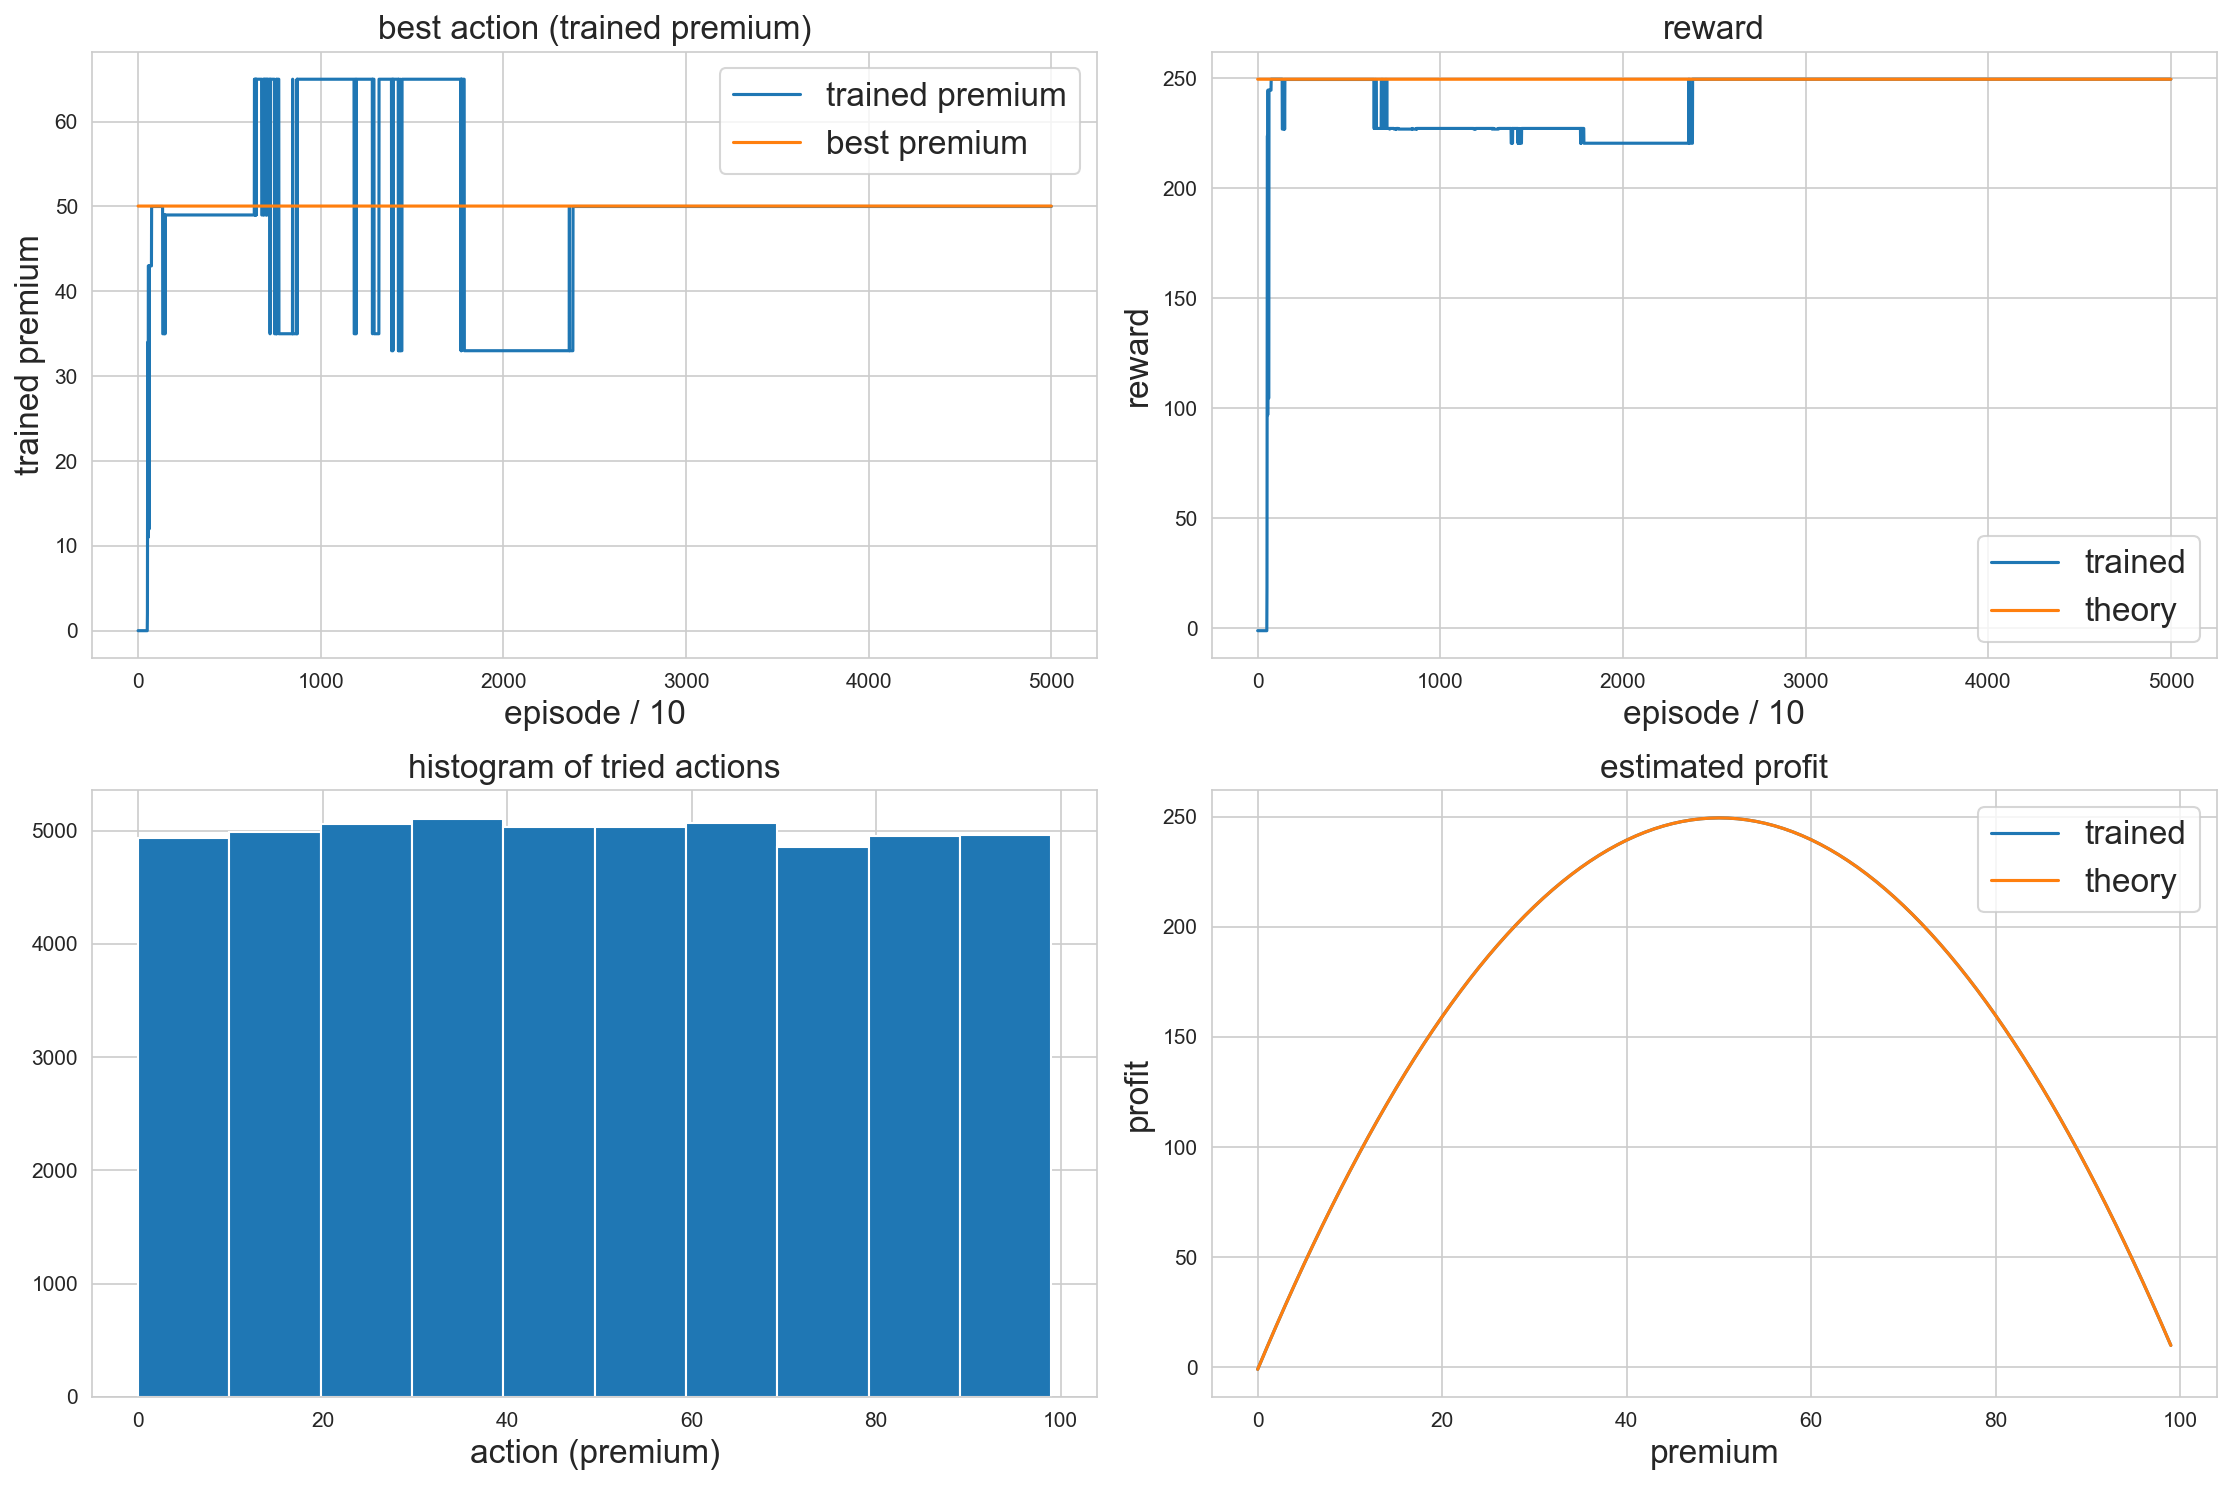

In [8]:
# test agent.
action = agent.act(env.state)
state, reward, _, done = env.step(action)
print('trained best action = {}, actual reward @ the action = {}'.format(action, reward))


# get maximum profit on theory
env.reset()
_, best_reward, _, _ = env.step(env.best_action())


# graph
fig, axs = plt.subplots(2, 2, figsize=(15, 10), dpi=150)

# score history
axs[0, 0].plot(np.array(best_actions), label='trained premium')
axs[0, 0].plot(np.ones(len(best_actions)) * env.best_action(), label='best premium')
axs[0, 0].set_title('best action (trained premium)', size=16)
axs[0, 0].set_xlabel('episode / 10', size=16)
axs[0, 0].set_ylabel('trained premium', size=16)
axs[0, 0].legend(fontsize=16)

axs[0, 1].plot(np.array(rewards), label='trained')
axs[0, 1].plot(np.ones(len(rewards)) * best_reward, label='theory')
axs[0, 1].set_title('reward', size=16)
axs[0, 1].set_xlabel('episode / 10', size=16)
axs[0, 1].set_ylabel('reward', size=16)
axs[0, 1].legend(fontsize=16)

# tried action histogram
axs[1, 0].hist(np.array(tried_actions))
axs[1, 0].set_title('histogram of tried actions', size=16)
axs[1, 0].set_xlabel('action (premium)', size=16)

# test Q function learned.
axs[1, 1].plot(np.array(q_func(np.array([0]).astype('float32').reshape(-1,1)).q_values.data).ravel(), label='trained')
axs[1, 1].plot(np.array(R), label='theory')
axs[1, 1].set_title('estimated profit', size=16)
axs[1, 1].set_xlabel('premium', size=16)
axs[1, 1].set_ylabel('profit', size=16)
axs[1, 1].legend(fontsize=16)

plt.tight_layout()
plt.show()

形式的にはこのように学習可能ではあるのだが，何故，ここまで大量のニューロンが必要なのだろうか？  
理論上は，結果を直接記録すればいいだけなので，バイアスが100個あれば十分な筈で，そもそも出力ニューロンだけで問題無い筈である（状態が1つしか無いので，入力は実質的に意味を持っておらず，出力ニューロン上のバイアスのみで表現可能）．しかし，実際にはそのようにすると，ほぼ学習できない．